In [2]:
#load data
import pandas as pd
def load_data(csv_file, sample_fraction=1.0):
    """Loads Question Pairs from a CSV file

    Args:
        csv_file (str): Path to csv_file
        sample_fraction (float): Fraction of data to sample, default is 1.0
    Returns:
        tuple: A tuple containing supervised data pairs
        returns [],[] on error
    """
    sentences1 = []
    sentences2 = []
    is_duplicate = []
    
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
        #print("Column names:", df.columns)
        
        if sample_fraction < 1.0:
            df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
        
        sentence1_series = df['question1']
        sentence2_series = df['question2']
        is_duplicate_series = df['is_duplicate']
        
        sentences1 = sentence1_series.tolist()
        sentences2 = sentence2_series.tolist()
        is_duplicate = is_duplicate_series.tolist()
        
        if len(sentences1) != len(sentences2):
            raise ValueError("The number of sentences in question1 and question2 do not match.")
        else:
            print(f"Loaded {len(sentences1)} sentences.")
        return sentences1, sentences2, is_duplicate
        
    except FileNotFoundError:
        print("Wrong Path")
        return [],[],[]
    
    except Exception as e:
        print(f"An {e} Error Occurred")
        return [],[],[]

DATA_PATH = r'C:/Users/Jash\Documents/Research\Semantic Equivilance\SemanticEquivilance/question_pairs/questions.csv'
sentences1, sentences2, value = load_data(DATA_PATH, sample_fraction=0.001)


Loaded 404 sentences.


In [62]:
import pennylane as qml
import numpy as np
from lambeq import AtomicType, BobcatParser, IQPAnsatz, PennyLaneModel, Rewriter
from discopy.quantum import Circuit # For hints/inspection
import random

def get_circuit_state_vector(qml_qnode_func, num_wires):
    """
    Executes a PennyLane QNode function and returns the state vector.
    The qml_qnode_func should return a qml.QNode object.
    """
    dev = qml.device("default.qubit", wires=num_wires)

    @qml.qnode(dev)
    def state_vector_wrapper():
        qml_qnode_func() # Execute the actual circuit operations
        return qml.state()

    return state_vector_wrapper()

def swap_test(state1_vec, state2_vec):
    """
    Performs a Quantum Swap Test between two quantum state vectors.

    Args:
        state1_vec (np.ndarray): The first state vector.
        state2_vec (np.ndarray): The second state vector.

    Returns:
        float: The estimated squared overlap (fidelity) between the two states.
    """
    num_qubits = int(np.log2(len(state1_vec)))
    if 2**num_qubits != len(state1_vec):
        raise ValueError("State vectors must have a length that is a power of 2.")

    total_qubits = 1 + 2 * num_qubits #1 Ancilla qubit + 2 state qubits

    dev = qml.device("default.qubit", wires=total_qubits, shots=1000) # N = 1000 runs of the circuit for statistical significance

    @qml.qnode(dev)
    def circuit():
        # Step 1: Prepare the ancilla qubit in a superposition
        qml.Hadamard(wires=0)
        
        # Step 2: Prepare the two input states
        qml.StatePrep(state1_vec, wires=range(1, 1 + num_qubits))
        qml.StatePrep(state2_vec, wires=range(1 + num_qubits, 1 + 2 * num_qubits))

        # Step 3: Apply controlled-SWAP gates
        for i in range(num_qubits):
            qml.CSWAP(wires=[0, 1 + i, 1 + num_qubits + i]) #selects every register of phi and psi for swap

        # Step 4: Apply Hadamard to ancilla
        qml.Hadamard(wires=0)
        # Step 5: Measure the ancilla qubit
        return qml.sample(wires=0)

    measurement_results = circuit()
    prob_0 = np.sum(measurement_results == 0) / len(measurement_results)
    squared_overlap = 2 * prob_0 - 1

    return squared_overlap

def lambeq_sentence_to_state_vector(sentence, ansatz, parser):
    """
    Converts a natural language sentence into a quantum state vector
    using Lambeq's BobcatParser and IQPAnsatz, handling parameterization
    via PennyLaneModel.

    Args:
        sentence (str): The input sentence.
        ansatz (lambeq.ansatz.Ansatz): The quantum ansatz to apply.
        parser (lambeq.parser.Parser): The parser to convert sentence to diagram.

    Returns:
        tuple: A tuple containing the state vector (np.ndarray) and
               the number of qubits (int).
    """
    diagram = parser.sentence2diagram(sentence)
    
    rewritten_diagram = rewriter(diagram) # type: ignore[reportArgumentType]
    normalized_diagram = rewritten_diagram.normal_form() # Normalize the diagram
    # print(f"\n--- Debugging: Sentence '{sentence}' ---")
    # print(f"DisCoPy Diagram (before ansatz):\n{diagram}")

    circuit = ansatz(normalized_diagram)
    # print(f"DisCoPy Circuit (after ansatz):\n{circuit}")
    circuit.draw(figsize=(20, 10), fontsize=6)#, draw_type_labels=False, fontsize=8,foliated=True) # Uncomment to visualize the circuit

    free_symbols = sorted(list(circuit.free_symbols), key=str)
    
    num_qubits = len(circuit.cod) #number of qubits is determined by the codomain of the circuit
    #print(f"{num_qubits} qubits")

    if num_qubits == 0:
        print(f"Warning: Sentence '{sentence}' resulted in a 0-qubit circuit (len(circuit.cod) is 0).")
        print("This means the ansatz is producing an empty output. Check your ansatz mapping and sentences.")
        return np.array([1, 0]), 1 # Default to |0> state for 1 qubit

    if not free_symbols and num_qubits > 0:
        print(f"Warning: Sentence '{sentence}' has no free symbols. The circuit is not parametric.")
        # This means the circuit does not have any tunable parameters.
        # We can still generate a state vector, but it will be static.
        return np.zeros(2**num_qubits), num_qubits

    try:
        model = PennyLaneModel([circuit]) # This is where the 'super' error likely originates internally

        # Parameters are only relevant if there are free symbols in the circuit
        params_values = np.array([random.uniform(0, 2 * np.pi) for _ in model.symbols])
        param_dict_for_debug = {str(sym): val for sym, val in zip(model.symbols, params_values)}
        print(f"Randomized Parameters for '{sentence}' (via PennyLaneModel): {param_dict_for_debug}")

        def qml_circuit_parametric():
            # This is the line that will trigger the "stack expects a non-empty tensorlist"
            # if PennyLaneModel failed to build a proper QNode.
            model(params_values)

        state_vec = get_circuit_state_vector(qml_circuit_parametric, num_qubits)
        state_vec = state_vec / np.linalg.norm(state_vec) # Ensure normalization
        return state_vec, num_qubits

    except Exception as e:
        print(f"CRITICAL ERROR: Failed to process circuit via PennyLaneModel for '{sentence}': {e}")
        print("This likely indicates a deeper compatibility issue between lambeq/discopy and PennyLane versions.")
        print("Returning a default normalized |0...0> state to allow program continuation.")
        # Generate a normalized |0...0> state for the given number of qubits
        # np.zeros(2**num_qubits) will create an all-zero vector,
        # then set the first element to 1 to represent |0...0>
        default_state = np.zeros(2**num_qubits)
        default_state[0] = 1.0
        return default_state, num_qubits

--- Generating states from sentences ---


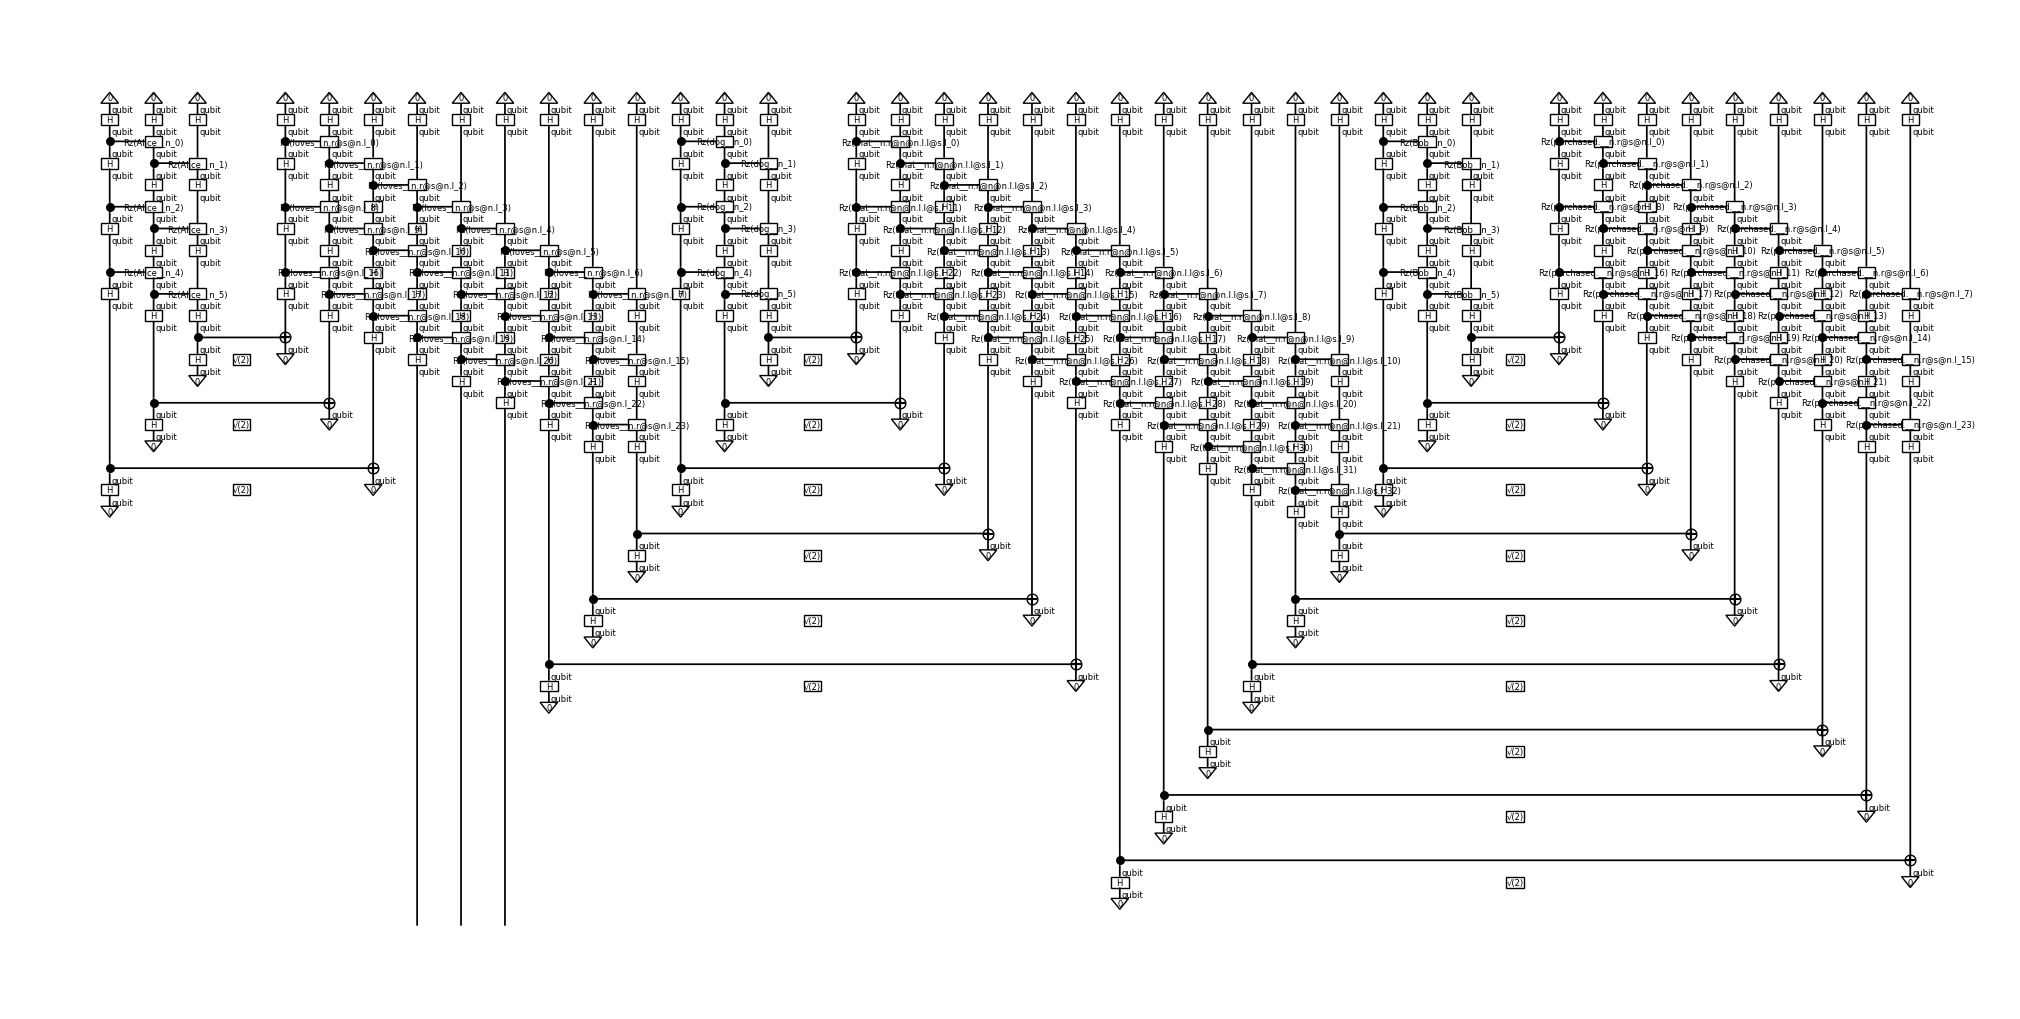

Randomized Parameters for 'Alice loves the dog that Bob purchased.' (via PennyLaneModel): {}
CRITICAL ERROR: Failed to process circuit via PennyLaneModel for 'Alice loves the dog that Bob purchased.': stack expects a non-empty TensorList
This likely indicates a deeper compatibility issue between lambeq/discopy and PennyLane versions.
Returning a default normalized |0...0> state to allow program continuation.
Sentence 1: 'Alice loves the dog that Bob purchased.'
Number of qubits: 3
State vector shape: (8,)


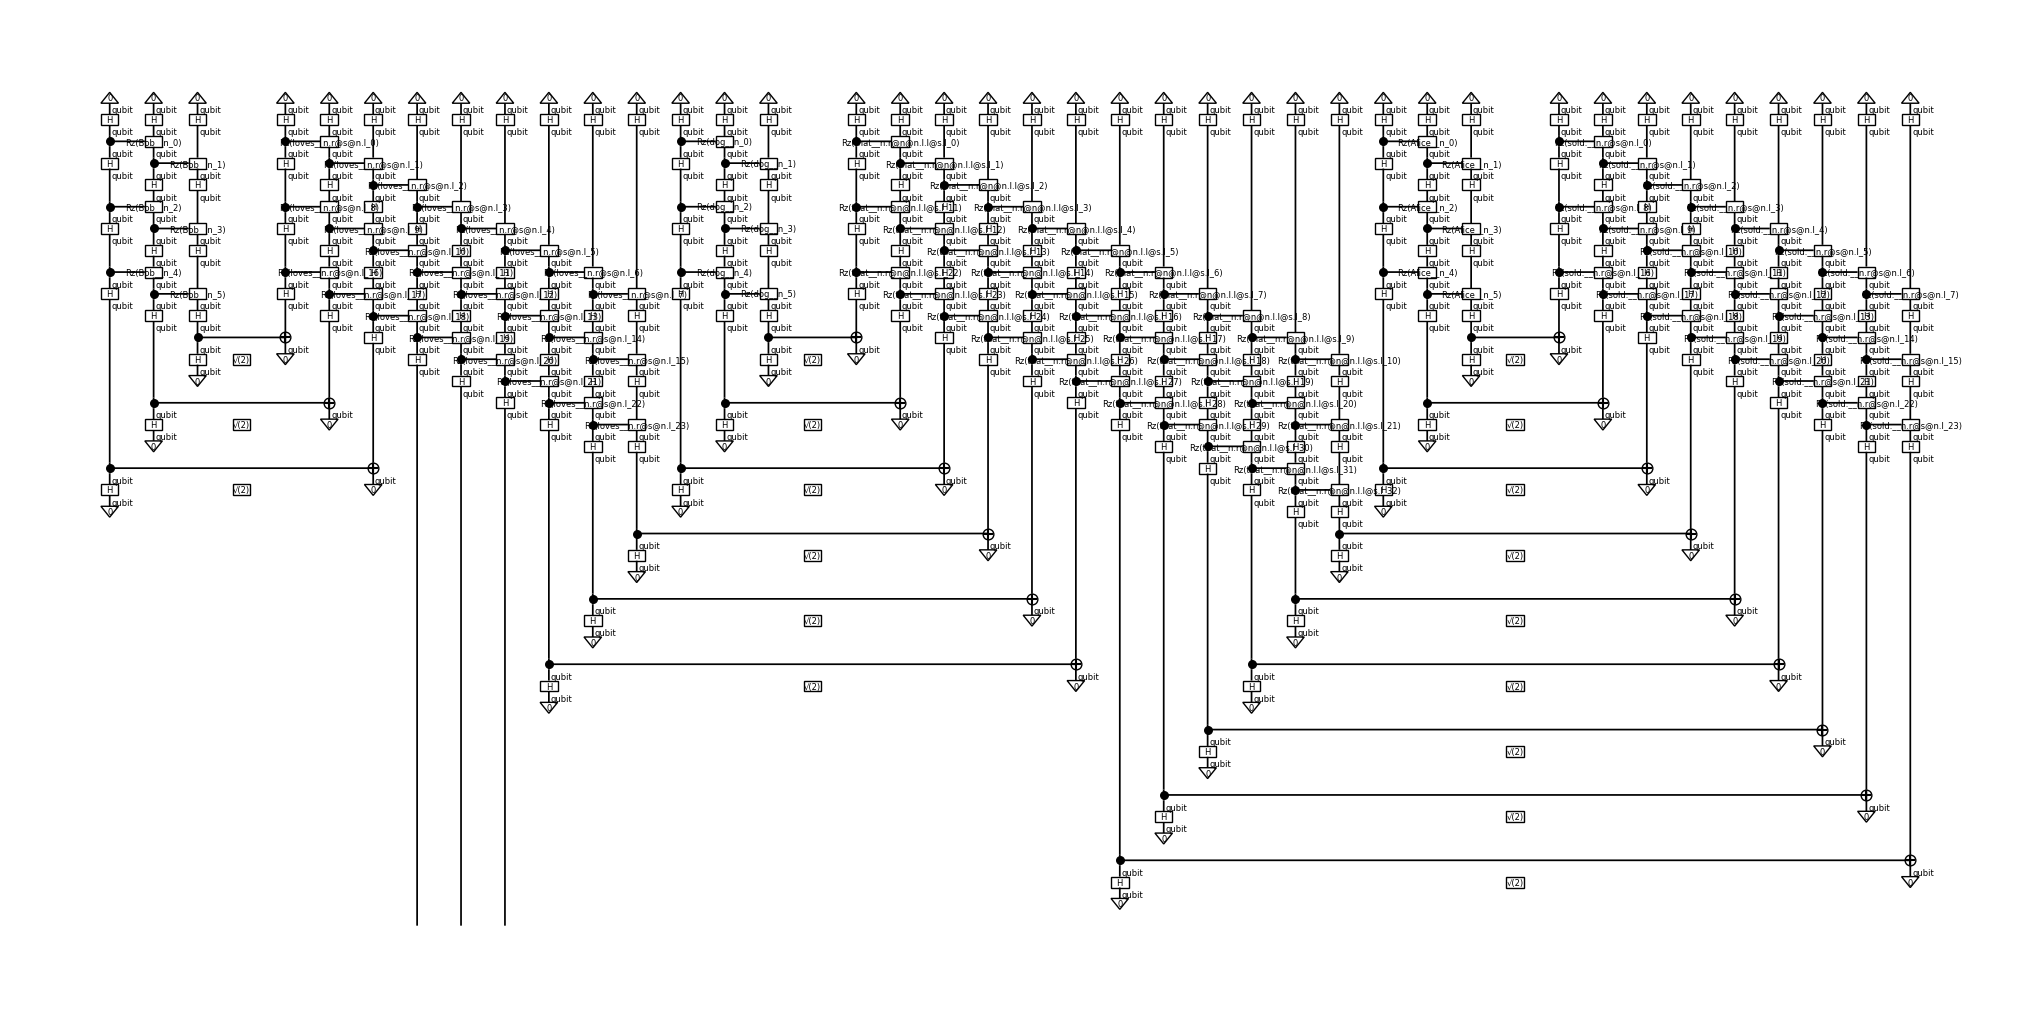

Randomized Parameters for 'Bob loves the dog that Alice sold.' (via PennyLaneModel): {}
CRITICAL ERROR: Failed to process circuit via PennyLaneModel for 'Bob loves the dog that Alice sold.': stack expects a non-empty TensorList
This likely indicates a deeper compatibility issue between lambeq/discopy and PennyLane versions.
Returning a default normalized |0...0> state to allow program continuation.
Sentence 2: 'Bob loves the dog that Alice sold.'
Number of qubits: 3
State vector shape: (8,)


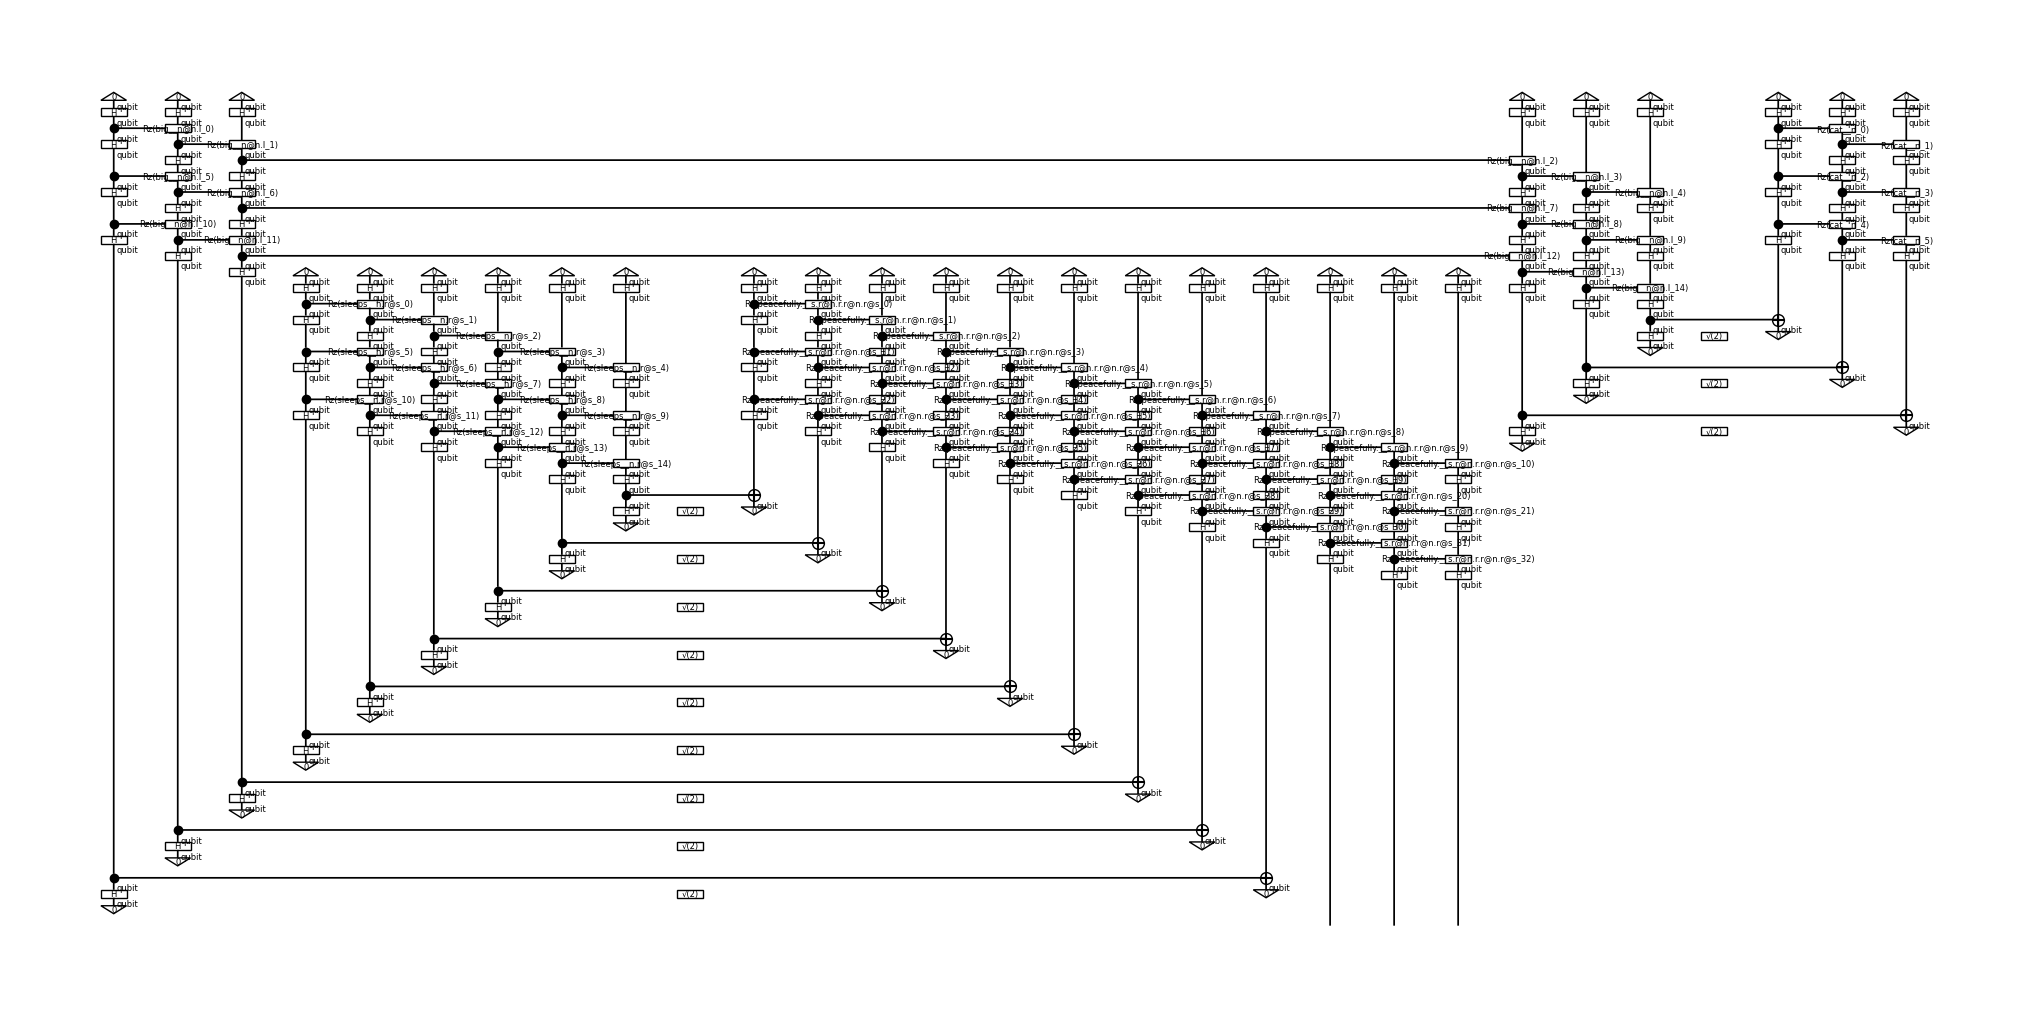

Randomized Parameters for 'The big cat sleeps peacefully.' (via PennyLaneModel): {}
CRITICAL ERROR: Failed to process circuit via PennyLaneModel for 'The big cat sleeps peacefully.': stack expects a non-empty TensorList
This likely indicates a deeper compatibility issue between lambeq/discopy and PennyLane versions.
Returning a default normalized |0...0> state to allow program continuation.
Sentence 3: 'The big cat sleeps peacefully.'
Number of qubits: 3
State vector shape: (8,)


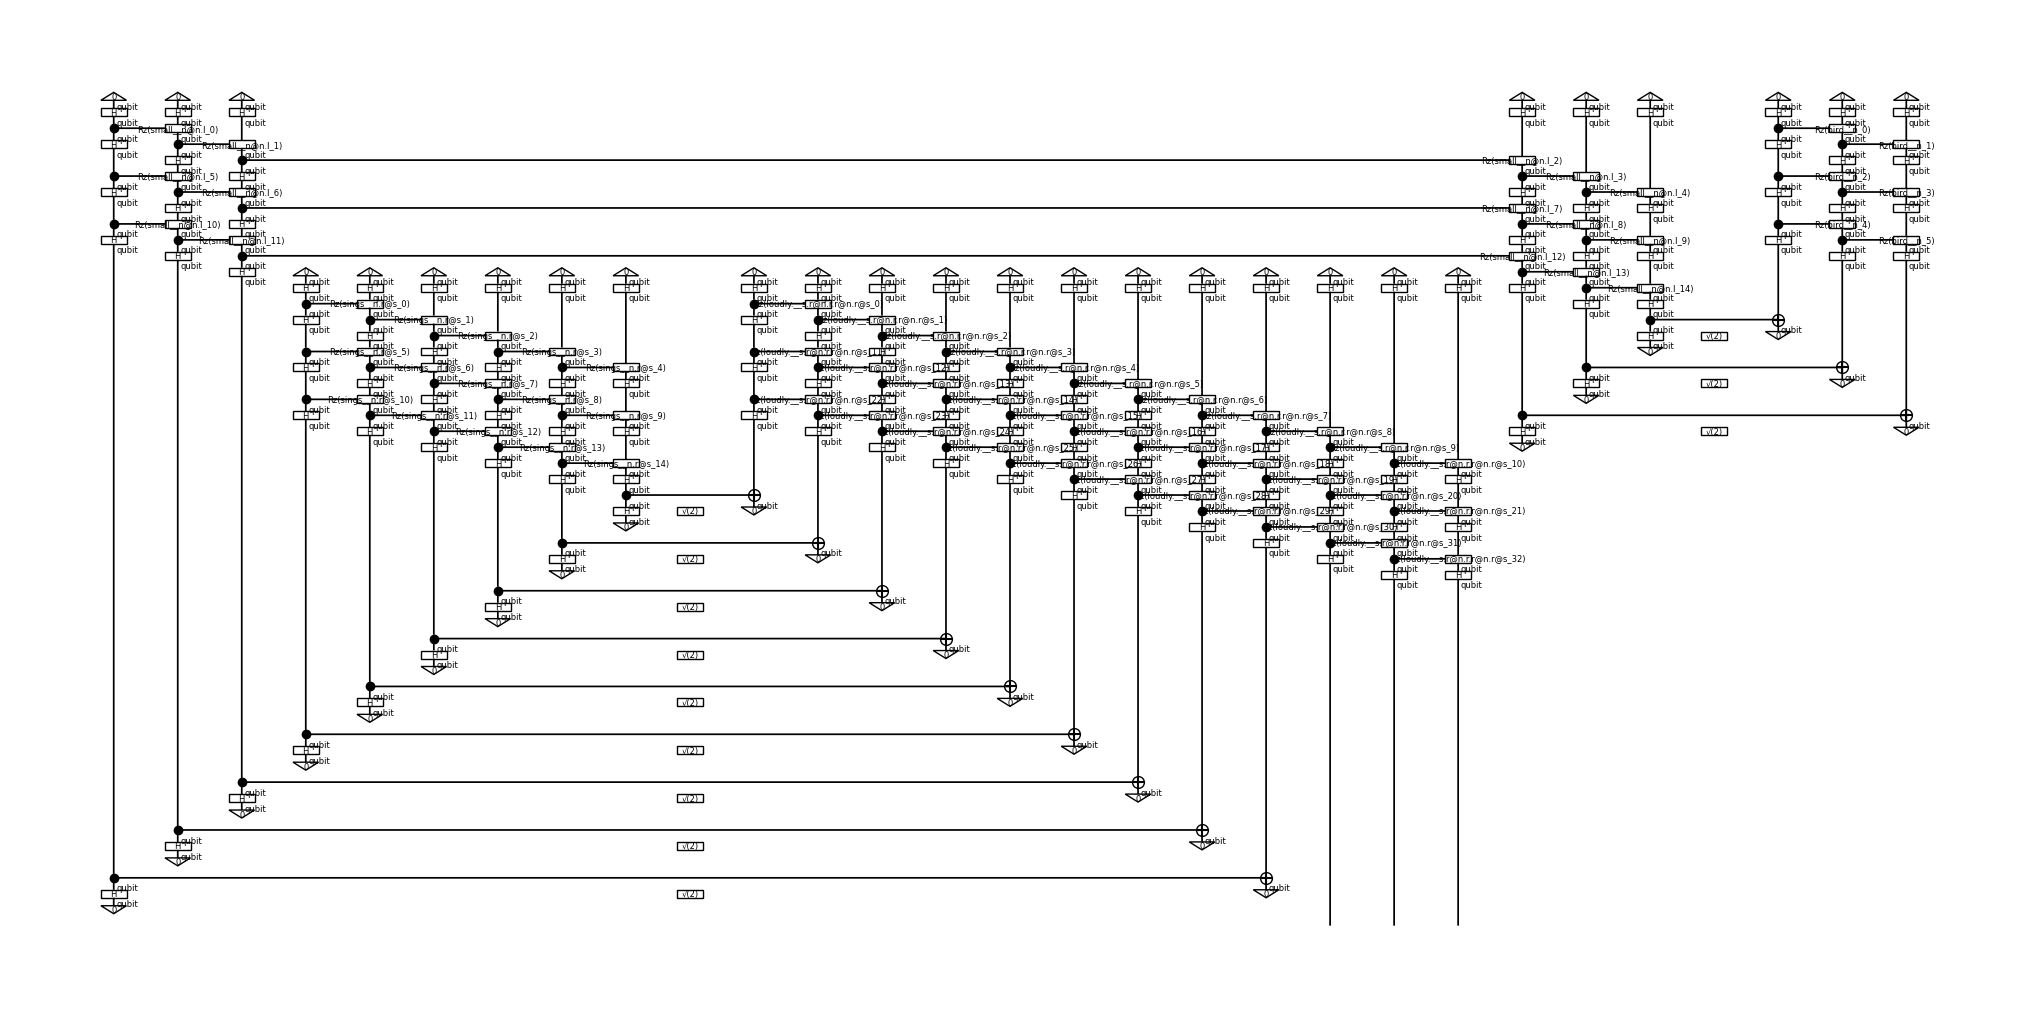

Randomized Parameters for 'The small bird sings loudly.' (via PennyLaneModel): {}
CRITICAL ERROR: Failed to process circuit via PennyLaneModel for 'The small bird sings loudly.': stack expects a non-empty TensorList
This likely indicates a deeper compatibility issue between lambeq/discopy and PennyLane versions.
Returning a default normalized |0...0> state to allow program continuation.
Sentence 4: 'The small bird sings loudly.'
Number of qubits: 3
State vector shape: (8,)

--- Performing Swap Tests ---

Swap Test between 'Alice loves the dog that Bob purchased.' and 'Alice loves the dog that Bob purchased.':
Estimated squared overlap: 1.0000
 (Expected to be close to 1.0 for identical states)

Swap Test between 'Alice loves the dog that Bob purchased.' and 'Bob loves the dog that Alice sold.':
Estimated squared overlap: 1.0000

Swap Test between 'Alice loves the dog that Bob purchased.' and 'The big cat sleeps peacefully.':
Estimated squared overlap: 1.0000

Swap Test between 'Alice l

In [ ]:
if __name__ == "__main__":
    parser = BobcatParser()
    rewriter = Rewriter(['curry', 'prepositional_phrase', 'determiner'])
    ansatz = IQPAnsatz({AtomicType.NOUN: 3, AtomicType.SENTENCE: 3}, n_layers=3)

    print("--- Generating states from sentences ---")

    sentence1 = "Alice loves the dog that Bob purchased."
    sentence2 = "Bob loves the dog that Alice sold."
    sentence3 = "The big cat sleeps peacefully."
    sentence4 = "The small bird sings loudly."

    sentences = [sentence1, sentence2, sentence3, sentence4]
    state_data = {}

    for s_idx, sentence in enumerate(sentences):
        try:
            state_vec, num_qubits = lambeq_sentence_to_state_vector(sentence, ansatz, parser)
            state_data[sentence] = (state_vec, num_qubits)
            print(f"Sentence {s_idx+1}: '{sentence}'")
            print(f"Number of qubits: {num_qubits}")
            print(f"State vector shape: {state_vec.shape}")
        except Exception as e:
            print(f"Error processing sentence '{sentence}': {e}")
            state_data[sentence] = (None, None) #Failed

    print("\n--- Performing Swap Tests ---")
    
    # Filter out sentences that did not produce valid states

    valid_sentences = [s for s in sentences if state_data[s][0] is not None and state_data[s][1] > 0]

    if not valid_sentences:
        print("No valid multi-qubit states generated. Cannot perform Swap Tests meaningfully.")
    else:
        first_num_qubits = state_data[valid_sentences[0]][1]
        all_same_qubits = all(state_data[s][1] == first_num_qubits for s in valid_sentences)

        if not all_same_qubits:
            print("\nWarning: Not all valid sentences resulted in circuits with the same number of qubits.")
            print("Swap Test requires states to have the same number of qubits.")
            print("Pairs with different qubit counts will be skipped.")
            for s in valid_sentences:
                print(f"  '{s}': {state_data[s][1]} qubits")

        for i in range(len(valid_sentences)):
            for j in range(i, len(valid_sentences)):
                s1 = valid_sentences[i]
                s2 = valid_sentences[j]

                vec1, nq1 = state_data[s1]
                vec2, nq2 = state_data[s2]

                if nq1 == nq2:
                    print(f"\nSwap Test between '{s1}' and '{s2}':")
                    overlap = swap_test(vec1, vec2)
                    print(f"Estimated squared overlap: {overlap:.4f}")
                    if s1 == s2:
                        print(" (Expected to be close to 1.0 for identical states)")
                else:
                    print(f"\nSkipping Swap Test between '{s1}' ({nq1} qubits) and '{s2}' ({nq2} qubits) due to different qubit counts.")

In [24]:
from lambeq import BobcatParser, SpacyTokeniser, Rewriter, AtomicType, IQPAnsatz
from lambeq.backend.grammar import Diagram as grammatical_diagram
from lambeq.backend.quantum import Diagram as quantum_circuit
from typing import Optional
import os, time, multiprocessing
os.environ["TOKENIZERS_PARALLELISM"] = "true" #environment variable for multithreading

#Global data sequencing variables
num_processes = multiprocessing.cpu_count()
print(f"Using {num_processes} processes.")

_tokenizer = None
_parser = None
_rewriter = None
_ansatz = None

def _initializer():
    global _tokenizer, _parser, _rewriter, _ansatz
    _tokenizer = SpacyTokeniser()  # Initialize tokenizer
    _parser = BobcatParser(verbose="suppress")  # Initialize parser 
    _rewriter = Rewriter(['prepositional_phrase', 'determiner'])  # Initialize rewriter
    _ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=2, n_single_qubit_params=3)  # Initialize ansatz


Using 12 processes.


In [ ]:
def process_data(sentence: str, tokeniser, parser, rewriter, ansatz) -> Optional[grammatical_diagram]:
    """Process a single sentence to a diagram.

    Args:
        sentence (str): Sentence to be converted to a diagram.

    Returns:
        Optional[quantum_circuit]: Either returns a diagram or None if an error occurs.
    """
    try:
        sentence = sentence.strip().lower()
        tokens = tokeniser.tokenise_sentence(sentence)
        diagram = parser.sentence2diagram(tokens, tokenised=True) #remove tokenization? might remove some errors 
        if diagram is not None:
            diagram = rewriter(diagram)
            normalised_diagram = diagram.normal_form()
            curry_functor = Rewriter(['curry'])
            curried_diagram = curry_functor(normalised_diagram)
            circuit = ansatz(curried_diagram)
            return circuit
        else:
            return None
    except Exception as e:
        print(f"Error processing sentence {sentence}")
        return None
def _process_data_for_pool(sentence: str) -> Optional[grammatical_diagram]:
    """Process a single sentence for the multiprocessing pool."""
    return process_data(sentence, _tokenizer, _parser, _rewriter, _ansatz)

def process_sentences(sentences: list[str]) -> list[Optional[grammatical_diagram]]:
    """Process sentences in parallel using multiprocessing.

    Args:
        sentences (list[str]): List of sentences to be processed.

    Returns:
        list[Optional[quantum_circuit]]: List of processed diagrams or None for errors.
    """
    start_time = time.time()
    batch_size = 50
    with multiprocessing.Pool(processes=num_processes, initializer=_initializer) as pool:
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i + batch_size]
            print(f"Processing batch {i // batch_size + 1} with {len(batch)} sentences.")
            current_batch = sentences[i:i + batch_size]
            
            batch_results = pool.map(_process_data_for_pool, current_batch)
        # Collect results from all batches
        #results = pool.map(_process_data_for_pool, sentences)
        end_time = time.time()
        print(f"Processed {len(sentences)} sentences in {end_time - start_time:.4f} seconds.")
    return batch_results